# Assignment 4 - Generative Adversarial Networks

Nathan Willemsen

DS552 - Generative AI | Prof. Narahara Chari Dingari, Ph.D.

February 7, 2026

### Assignment Overview
This assignment implements and experiments with Generative Adversarial Networks (GANs). We begin by building a GAN trained on the MNIST dataset, then improve the architecture with additional convolutional layers, implement image saving for training visualization, and finally adapt the network for the CIFAR-10 dataset.

#### Key Concepts
- Implementing a GAN with a generator and discriminator trained adversarially
- Modifying the generator with additional convolutional layers for improved quality
- Saving generated images every 10 epochs to visualize training progress
- Adapting the GAN architecture from MNIST (28×28×1) to CIFAR-10 (32×32×3)

## Theory Questions

***Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.***

The minimax loss function in GANs is defined as:

$$\min_G \max_D \; \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

The discriminator $D$ tries to **maximize** this objective: it wants $D(x) \to 1$ for real data (making $\log D(x)$ large) and $D(G(z)) \to 0$ for fake data (making $\log(1 - D(G(z)))$ large). Meanwhile, the generator $G$ tries to **minimize** the same objective by producing images that fool $D$ into outputting $D(G(z)) \to 1$, which drives $\log(1 - D(G(z)))$ toward $-\infty$.

This creates a two-player game where improvements by one player create pressure on the other to improve. If the discriminator becomes too good, the generator receives stronger gradient signals to produce more realistic images. If the generator improves, the discriminator must learn finer distinctions between real and fake. At the theoretical Nash equilibrium, the generator produces samples indistinguishable from real data and the discriminator outputs 0.5 for all inputs.

***Q2: What is mode collapse? Why can mode collapse occur during GAN training, and how can it be mitigated?***

Mode collapse occurs when the generator learns to produce only a small subset of possible outputs rather than capturing the full diversity of the data distribution. For example, a GAN trained on MNIST might generate only a few digit classes convincingly while ignoring others.

Mode collapse happens because the generator finds a "safe" output that consistently fools the discriminator and over-optimizes for that particular mode. The minimax objective doesn't explicitly penalize lack of diversity—it only rewards fooling the discriminator. The discriminator eventually catches on and the generator jumps to a different mode, creating oscillatory behavior without convergence.

Mitigation strategies include:
- **Minibatch discrimination**: Allowing the discriminator to compare samples within a batch, detecting when the generator produces similar outputs.
- **Unrolled GANs**: Computing the generator's loss with respect to future discriminator updates, discouraging mode-hopping.
- **Wasserstein loss (WGAN)**: Replacing the JS divergence with the Earth Mover's distance, which provides smoother gradients and more stable training.
- **Feature matching**: Training the generator to match intermediate feature statistics of the discriminator on real data rather than maximizing the discriminator's output directly.

***Q3: Explain the role of the discriminator in adversarial training.***

The discriminator serves as a learned loss function for the generator. Rather than using a fixed pixel-level metric (like MSE), the discriminator learns to identify increasingly subtle differences between real and generated images, providing the generator with meaningful gradient signals about what makes images look unrealistic.

During training, the discriminator is updated to classify real images as 1 and generated images as 0. These classification decisions produce gradients that flow back through the generator, telling it how to adjust its parameters to produce more realistic outputs. The discriminator essentially learns to capture the statistics of the real data distribution and communicates deviations to the generator through backpropagation.

A well-balanced discriminator is critical: if it's too weak, it provides uninformative gradients; if it's too strong, gradients can vanish (since the generator's outputs are confidently rejected), making training unstable.

***Q4: How do metrics like IS and FID evaluate GAN performance?***

**Inception Score (IS)** feeds generated images through a pre-trained Inception network and evaluates two properties: (1) each image should have a confident, low-entropy class prediction (high quality), and (2) the marginal distribution over all generated images should be high-entropy (high diversity). IS is computed as $\exp(\mathbb{E}[D_{KL}(p(y|x) \| p(y))])$. Higher IS indicates better quality and diversity. However, IS doesn't compare to real data directly and can miss intra-class mode collapse.

**Fréchet Inception Distance (FID)** extracts features from both real and generated images using an Inception network, models each set as a multivariate Gaussian, and computes the Fréchet distance between the two distributions: $FID = \|\mu_r - \mu_g\|^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$. Lower FID indicates that generated images are more similar to real images in feature space. FID is generally considered more robust than IS because it directly compares to the real data distribution and is more sensitive to mode dropping.

## Part 1: MNIST GAN — Base Implementation

We start with a basic DCGAN architecture

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2026-02-09 14:37:05.551432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
GPU available: False


In [2]:
# Load and preprocess MNIST data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_DIM = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Training images shape: {train_images.shape}")
print(f"Pixel range: [{train_images.min():.1f}, {train_images.max():.1f}]")
print(f"Number of batches: {len(train_dataset)}")

Training images shape: (60000, 28, 28, 1)
Pixel range: [-1.0, 1.0]
Number of batches: 235


In [3]:
def make_generator_model():
    """Generator: maps 100-dim noise vector to 28x28x1 image.
    Uses transposed convolutions to progressively upsample.
    """
    model = tf.keras.Sequential([
        # Project and reshape: 100 -> 7x7x256
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),

        # Upsample: 7x7x256 -> 7x7x128
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 7x7x128 -> 14x14x64
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Output: 14x14x64 -> 28x28x1
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


def make_discriminator_model():
    """Discriminator: classifies 28x28x1 images as real or fake.
    Uses strided convolutions to progressively downsample.
    """
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)  # Logit output
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

/opt/anaconda3/envs/genai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/genai/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """D wants real -> 1, fake -> 0"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    """G wants fake -> 1 (fool discriminator)"""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [5]:
# Fixed seed for consistent visualization across epochs
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# Create output directory for saved images
os.makedirs('mnist_gan_images', exist_ok=True)

def save_generated_images(model, epoch, test_input, save_dir='mnist_gan_images'):
    """Generate and save a grid of images."""
    predictions = model(test_input, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.axis('off')
    fig.suptitle(f'MNIST GAN — Epoch {epoch}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch:04d}.png'), dpi=100)
    plt.show()
    plt.close()


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    gen_losses, disc_losses = [], []

    for epoch in range(1, epochs + 1):
        start = time.time()
        epoch_gen_loss, epoch_disc_loss = 0.0, 0.0
        num_batches = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss += g_loss
            epoch_disc_loss += d_loss
            num_batches += 1

        avg_gen = epoch_gen_loss / num_batches
        avg_disc = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen.numpy())
        disc_losses.append(avg_disc.numpy())

        if epoch % 10 == 0 or epoch == 1:
            save_generated_images(generator, epoch, seed) # Save images every 10 epochs

        elapsed = time.time() - start
        print(f'Epoch {epoch:3d}/{epochs} | G Loss: {avg_gen:.4f} | D Loss: {avg_disc:.4f} | Time: {elapsed:.1f}s')

    return gen_losses, disc_losses

2026-02-09 14:43:50.136697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


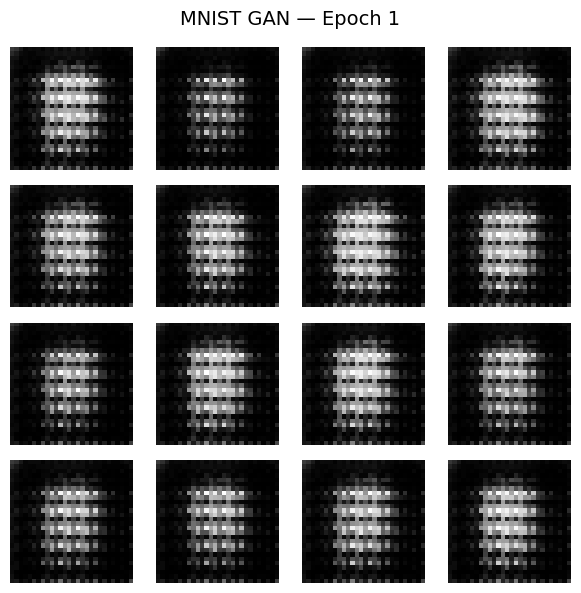

Epoch   1/50 | G Loss: 0.6801 | D Loss: 1.1452 | Time: 277.6s


2026-02-09 14:48:07.977343: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   2/50 | G Loss: 0.9147 | D Loss: 1.1529 | Time: 256.2s
Epoch   3/50 | G Loss: 1.4001 | D Loss: 0.8502 | Time: 228.1s


2026-02-09 14:55:57.815581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   4/50 | G Loss: 0.9568 | D Loss: 1.1735 | Time: 241.7s
Epoch   5/50 | G Loss: 0.9536 | D Loss: 1.2426 | Time: 940.3s
Epoch   6/50 | G Loss: 0.9002 | D Loss: 1.2193 | Time: 245.5s
Epoch   7/50 | G Loss: 0.9298 | D Loss: 1.2006 | Time: 234.5s


2026-02-09 15:23:23.653026: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   8/50 | G Loss: 1.0057 | D Loss: 1.1769 | Time: 225.5s
Epoch   9/50 | G Loss: 1.0080 | D Loss: 1.1677 | Time: 214.4s


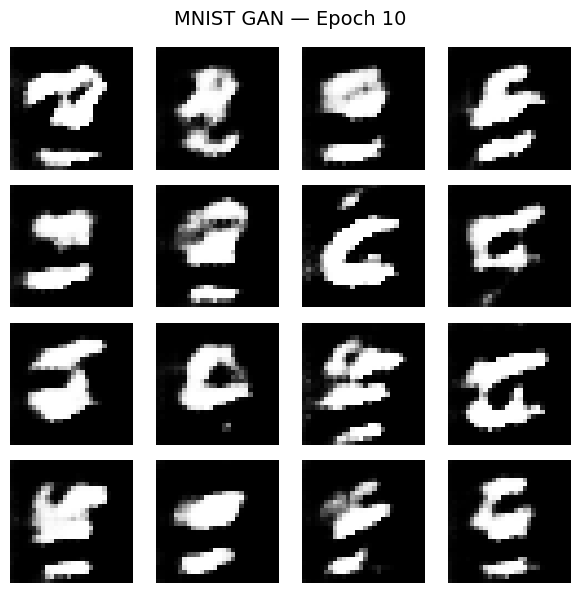

Epoch  10/50 | G Loss: 1.0332 | D Loss: 1.1691 | Time: 222.0s
Epoch  11/50 | G Loss: 1.0494 | D Loss: 1.1504 | Time: 222.6s
Epoch  12/50 | G Loss: 0.9959 | D Loss: 1.1489 | Time: 213.2s
Epoch  13/50 | G Loss: 1.0606 | D Loss: 1.1401 | Time: 211.1s
Epoch  14/50 | G Loss: 1.1770 | D Loss: 1.0081 | Time: 213.1s
Epoch  15/50 | G Loss: 1.1256 | D Loss: 1.0853 | Time: 215.2s


2026-02-09 15:52:06.780733: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  16/50 | G Loss: 1.1931 | D Loss: 1.0265 | Time: 211.5s
Epoch  17/50 | G Loss: 1.2261 | D Loss: 1.0010 | Time: 241.6s
Epoch  18/50 | G Loss: 1.3203 | D Loss: 0.9829 | Time: 222.3s
Epoch  19/50 | G Loss: 1.2086 | D Loss: 1.0586 | Time: 214.5s


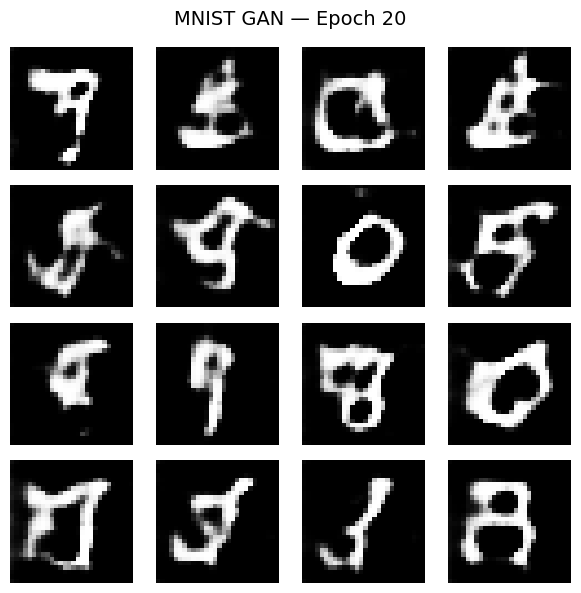

Epoch  20/50 | G Loss: 1.2016 | D Loss: 1.0526 | Time: 212.1s
Epoch  21/50 | G Loss: 1.1886 | D Loss: 1.0678 | Time: 212.7s
Epoch  22/50 | G Loss: 1.2159 | D Loss: 1.0727 | Time: 214.2s
Epoch  23/50 | G Loss: 1.1566 | D Loss: 1.0766 | Time: 211.5s
Epoch  24/50 | G Loss: 1.1484 | D Loss: 1.1090 | Time: 231.6s
Epoch  25/50 | G Loss: 1.0698 | D Loss: 1.1506 | Time: 316.5s
Epoch  26/50 | G Loss: 1.1177 | D Loss: 1.0973 | Time: 336.2s
Epoch  27/50 | G Loss: 1.0928 | D Loss: 1.1449 | Time: 350.6s
Epoch  28/50 | G Loss: 1.0578 | D Loss: 1.1636 | Time: 271.2s
Epoch  29/50 | G Loss: 1.0619 | D Loss: 1.1934 | Time: 214.6s


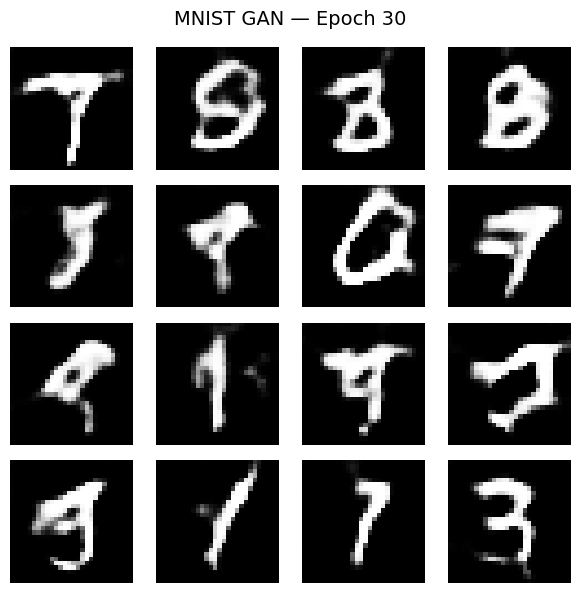

Epoch  30/50 | G Loss: 1.0463 | D Loss: 1.1622 | Time: 216.6s
Epoch  31/50 | G Loss: 1.0063 | D Loss: 1.1918 | Time: 214.6s


2026-02-09 16:57:01.015389: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  32/50 | G Loss: 1.0008 | D Loss: 1.1923 | Time: 213.6s
Epoch  33/50 | G Loss: 0.9530 | D Loss: 1.1967 | Time: 215.3s
Epoch  34/50 | G Loss: 0.9354 | D Loss: 1.2059 | Time: 214.3s
Epoch  35/50 | G Loss: 0.9690 | D Loss: 1.1947 | Time: 213.4s
Epoch  36/50 | G Loss: 0.9728 | D Loss: 1.2012 | Time: 213.6s
Epoch  37/50 | G Loss: 0.9853 | D Loss: 1.1972 | Time: 213.9s
Epoch  38/50 | G Loss: 1.0054 | D Loss: 1.1952 | Time: 216.1s
Epoch  39/50 | G Loss: 1.0242 | D Loss: 1.1784 | Time: 216.5s


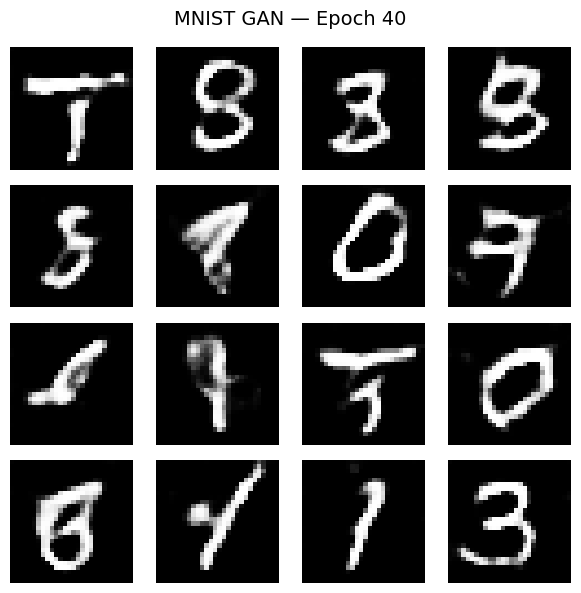

Epoch  40/50 | G Loss: 0.9967 | D Loss: 1.1912 | Time: 216.2s
Epoch  41/50 | G Loss: 0.9723 | D Loss: 1.2123 | Time: 214.2s
Epoch  42/50 | G Loss: 0.9684 | D Loss: 1.2065 | Time: 220.6s
Epoch  43/50 | G Loss: 0.9758 | D Loss: 1.1958 | Time: 216.8s
Epoch  44/50 | G Loss: 0.9581 | D Loss: 1.2028 | Time: 220.0s
Epoch  45/50 | G Loss: 0.9943 | D Loss: 1.1980 | Time: 215.6s
Epoch  46/50 | G Loss: 0.9964 | D Loss: 1.1931 | Time: 212.6s
Epoch  47/50 | G Loss: 0.9807 | D Loss: 1.1984 | Time: 214.7s
Epoch  48/50 | G Loss: 0.9858 | D Loss: 1.2023 | Time: 215.3s
Epoch  49/50 | G Loss: 1.0093 | D Loss: 1.1876 | Time: 214.5s


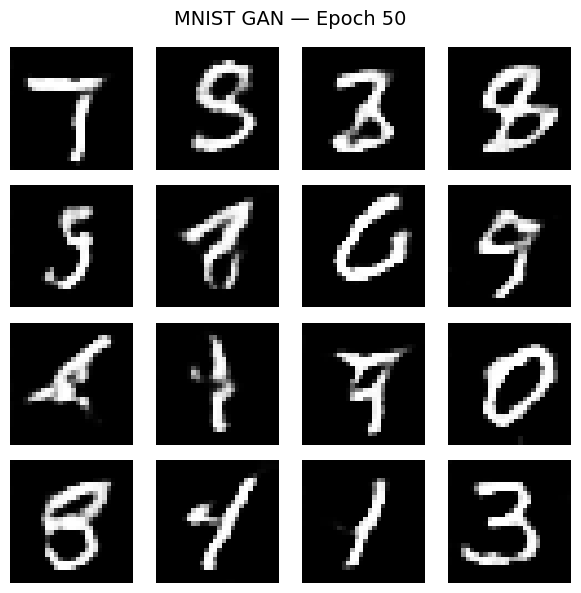

Epoch  50/50 | G Loss: 1.0302 | D Loss: 1.1587 | Time: 212.8s


In [6]:
# Train the MNIST GAN
EPOCHS = 50
gen_losses, disc_losses = train(train_dataset, EPOCHS)

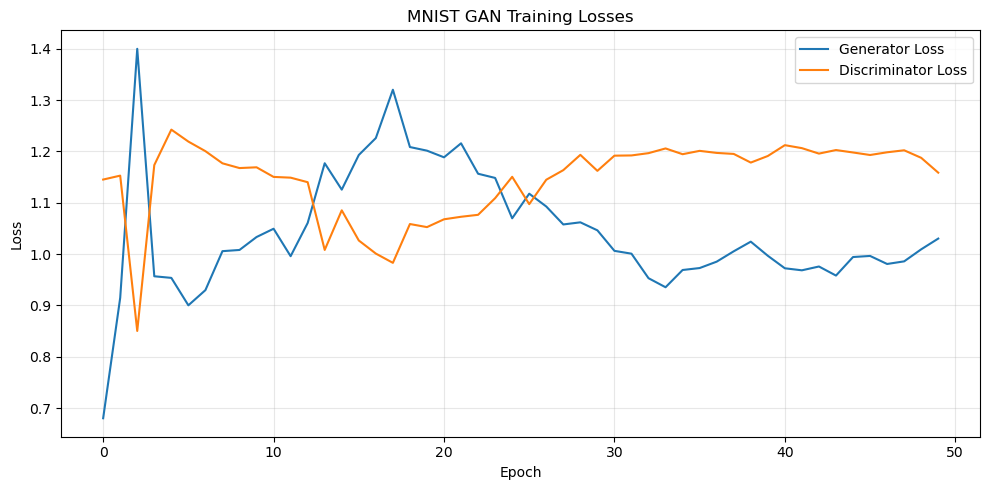

In [7]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MNIST GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Improved Generator with Additional Convolutional Layers

We add extra convolutional layers to the generator for richer feature representations and potentially higher quality outputs.

In [8]:
def make_improved_generator():
    model = tf.keras.Sequential([
        # Project and reshape
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),

        # Additional conv layer: 7x7x256 -> 7x7x256
        layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 7x7x256 -> 7x7x128
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Additional conv layer: 7x7x128 -> 7x7x128
        layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 7x7x128 -> 14x14x64
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Additional conv layer: 14x14x64 -> 14x14x64
        layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Output: 14x14x64 -> 28x28x1
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


def make_improved_discriminator():
    """Improved discriminator with additional conv layers."""
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # Additional conv layer
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # Additional conv layer
        layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator_v2 = make_improved_generator()
discriminator_v2 = make_improved_discriminator()

print("Improved Generator")
generator_v2.summary()
print(f"\nOriginal generator params: {generator.count_params():,}")
print(f"Improved generator params: {generator_v2.count_params():,}")
print(f"\nImproved Discriminator")
discriminator_v2.summary()

Improved Generator


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 256)      │       589,824 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 7, 7, 128)      │       147,456 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │        36,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,106,880 (11.85 MB)

 Trainable params: 3,080,512 (11.75 MB)

 Non-trainable params: 26,368 (103.00 KB)


Original generator params: 2,330,944
Improved generator params: 3,106,880

Improved Discriminator


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,377 (1.52 MB)

 Trainable params: 397,377 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Optimizers
gen_optimizer_v2 = tf.keras.optimizers.Adam(1e-4)
disc_optimizer_v2 = tf.keras.optimizers.Adam(1e-4)

os.makedirs('mnist_gan_v2_images', exist_ok=True)
seed_v2 = tf.random.normal([num_examples_to_generate, NOISE_DIM])


@tf.function
def train_step_v2(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_v2(noise, training=True)
        real_output = discriminator_v2(images, training=True)
        fake_output = discriminator_v2(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_grads = gen_tape.gradient(gen_loss, generator_v2.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator_v2.trainable_variables)

    gen_optimizer_v2.apply_gradients(zip(gen_grads, generator_v2.trainable_variables))
    disc_optimizer_v2.apply_gradients(zip(disc_grads, discriminator_v2.trainable_variables))

    return gen_loss, disc_loss


def train_v2(dataset, epochs):
    gen_losses, disc_losses = [], []

    for epoch in range(1, epochs + 1):
        start = time.time()
        epoch_gen_loss, epoch_disc_loss = 0.0, 0.0
        num_batches = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step_v2(image_batch)
            epoch_gen_loss += g_loss
            epoch_disc_loss += d_loss
            num_batches += 1

        avg_gen = epoch_gen_loss / num_batches
        avg_disc = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen.numpy())
        disc_losses.append(avg_disc.numpy())

        if epoch % 10 == 0 or epoch == 1:
            save_generated_images(generator_v2, epoch, seed_v2, save_dir='mnist_gan_v2_images') # Save improved images

        elapsed = time.time() - start
        print(f'Epoch {epoch:3d}/{epochs} | G Loss: {avg_gen:.4f} | D Loss: {avg_disc:.4f} | Time: {elapsed:.1f}s')

    return gen_losses, disc_losses



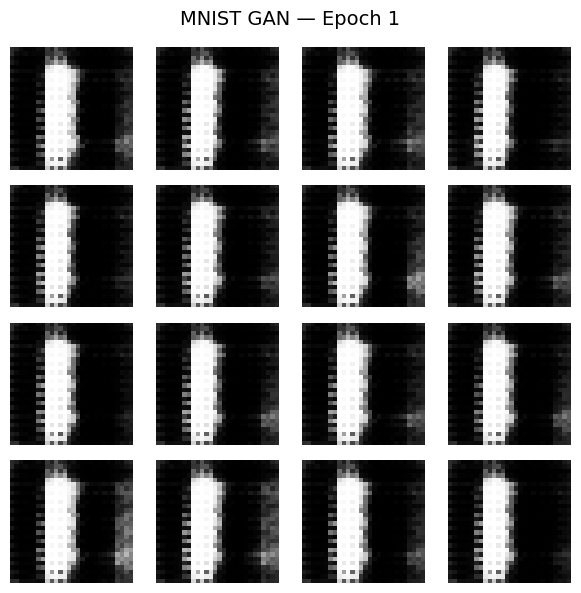

Epoch   1/50 | G Loss: 0.8918 | D Loss: 1.0678 | Time: 451.0s
Epoch   2/50 | G Loss: 1.3746 | D Loss: 0.9613 | Time: 423.6s
Epoch   3/50 | G Loss: 1.9387 | D Loss: 0.6846 | Time: 423.2s
Epoch   4/50 | G Loss: 1.6371 | D Loss: 0.8790 | Time: 422.2s
Epoch   5/50 | G Loss: 1.3011 | D Loss: 1.0060 | Time: 436.8s
Epoch   6/50 | G Loss: 1.1412 | D Loss: 1.0977 | Time: 425.3s
Epoch   7/50 | G Loss: 1.3229 | D Loss: 1.0036 | Time: 424.8s
Epoch   8/50 | G Loss: 1.4355 | D Loss: 0.9257 | Time: 422.1s
Epoch   9/50 | G Loss: 1.4861 | D Loss: 0.9225 | Time: 525.9s


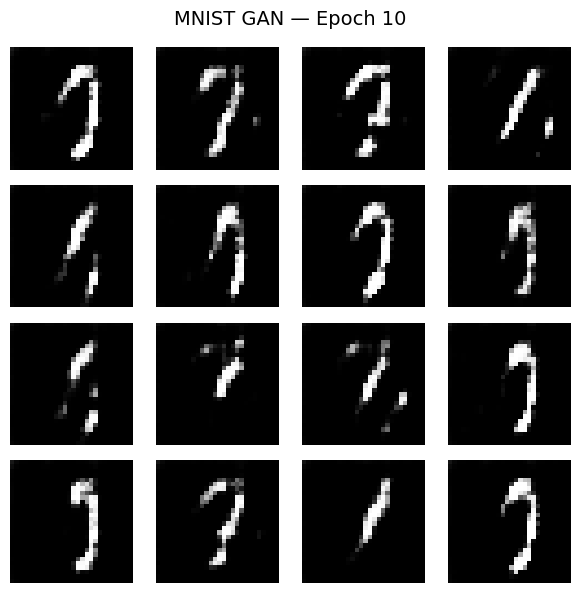

Epoch  10/50 | G Loss: 1.3171 | D Loss: 0.9589 | Time: 651.3s
Epoch  11/50 | G Loss: 1.3982 | D Loss: 0.9880 | Time: 662.7s
Epoch  12/50 | G Loss: 1.5399 | D Loss: 0.9361 | Time: 680.7s
Epoch  13/50 | G Loss: 1.7242 | D Loss: 0.7831 | Time: 643.1s


2026-02-09 22:02:33.329907: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  14/50 | G Loss: 1.9199 | D Loss: 0.7823 | Time: 536.6s
Epoch  15/50 | G Loss: 1.8687 | D Loss: 0.7495 | Time: 550.2s
Epoch  16/50 | G Loss: 1.7272 | D Loss: 0.7914 | Time: 541.6s
Epoch  17/50 | G Loss: 1.6838 | D Loss: 0.8414 | Time: 531.4s
Epoch  18/50 | G Loss: 1.5233 | D Loss: 0.9038 | Time: 490.5s
Epoch  19/50 | G Loss: 1.6512 | D Loss: 0.8280 | Time: 471.6s


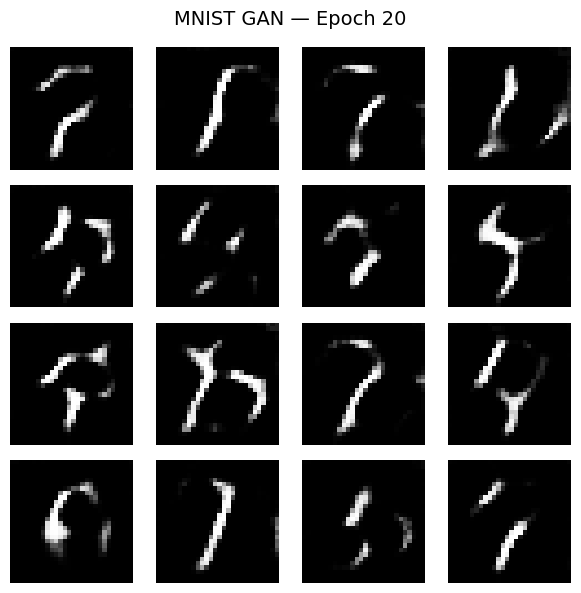

Epoch  20/50 | G Loss: 1.3956 | D Loss: 0.9434 | Time: 428.0s
Epoch  21/50 | G Loss: 1.4678 | D Loss: 0.9417 | Time: 444.2s
Epoch  22/50 | G Loss: 1.4735 | D Loss: 0.8774 | Time: 428.7s
Epoch  23/50 | G Loss: 1.5367 | D Loss: 0.9138 | Time: 420.1s
Epoch  24/50 | G Loss: 1.4182 | D Loss: 0.9239 | Time: 418.2s
Epoch  25/50 | G Loss: 1.3764 | D Loss: 0.9407 | Time: 421.7s
Epoch  26/50 | G Loss: 1.3692 | D Loss: 0.9575 | Time: 433.4s
Epoch  27/50 | G Loss: 1.3691 | D Loss: 0.9862 | Time: 459.0s
Epoch  28/50 | G Loss: 1.3618 | D Loss: 0.9704 | Time: 439.7s
Epoch  29/50 | G Loss: 1.2911 | D Loss: 1.0073 | Time: 443.1s


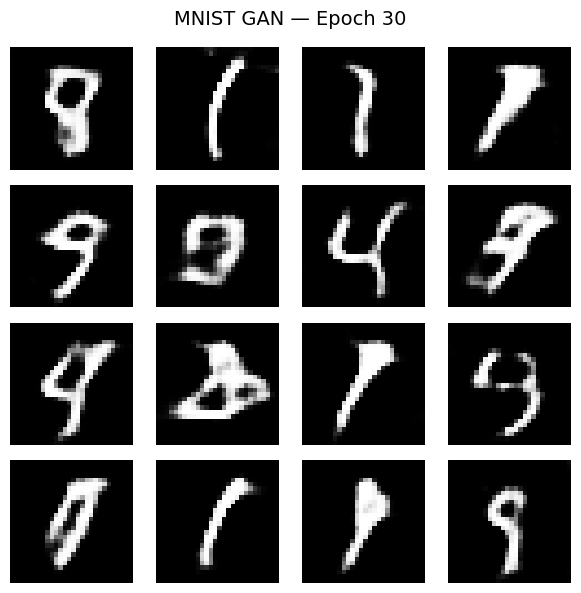

Epoch  30/50 | G Loss: 1.2108 | D Loss: 1.0517 | Time: 443.5s
Epoch  31/50 | G Loss: 1.1347 | D Loss: 1.0815 | Time: 445.1s
Epoch  32/50 | G Loss: 1.1875 | D Loss: 1.0727 | Time: 448.7s
Epoch  33/50 | G Loss: 1.2562 | D Loss: 1.0512 | Time: 457.3s
Epoch  34/50 | G Loss: 1.1531 | D Loss: 1.0754 | Time: 468.5s
Epoch  35/50 | G Loss: 1.0701 | D Loss: 1.1620 | Time: 477.4s
Epoch  36/50 | G Loss: 1.0718 | D Loss: 1.1351 | Time: 451.1s
Epoch  37/50 | G Loss: 1.0705 | D Loss: 1.1311 | Time: 442.7s
Epoch  38/50 | G Loss: 1.0273 | D Loss: 1.1547 | Time: 435.2s
Epoch  39/50 | G Loss: 1.1004 | D Loss: 1.1494 | Time: 438.1s


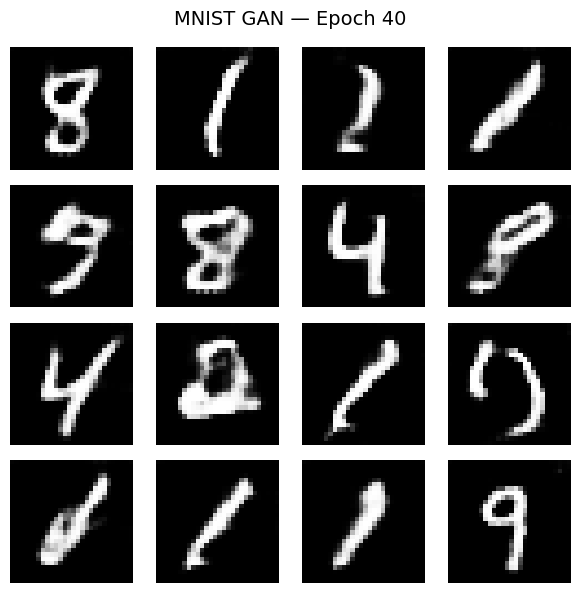

Epoch  40/50 | G Loss: 0.9761 | D Loss: 1.1717 | Time: 437.9s
Epoch  41/50 | G Loss: 1.0160 | D Loss: 1.1721 | Time: 435.3s
Epoch  42/50 | G Loss: 0.9796 | D Loss: 1.1863 | Time: 434.1s
Epoch  43/50 | G Loss: 1.0371 | D Loss: 1.1723 | Time: 443.3s
Epoch  44/50 | G Loss: 0.9772 | D Loss: 1.1967 | Time: 5117.4s
Epoch  45/50 | G Loss: 0.9749 | D Loss: 1.1896 | Time: 3538.3s
Epoch  46/50 | G Loss: 0.9911 | D Loss: 1.1909 | Time: 782.0s
Epoch  47/50 | G Loss: 1.0188 | D Loss: 1.1739 | Time: 9337.4s
Epoch  48/50 | G Loss: 1.0053 | D Loss: 1.1752 | Time: 2608.6s
Epoch  49/50 | G Loss: 1.0045 | D Loss: 1.1792 | Time: 706.8s


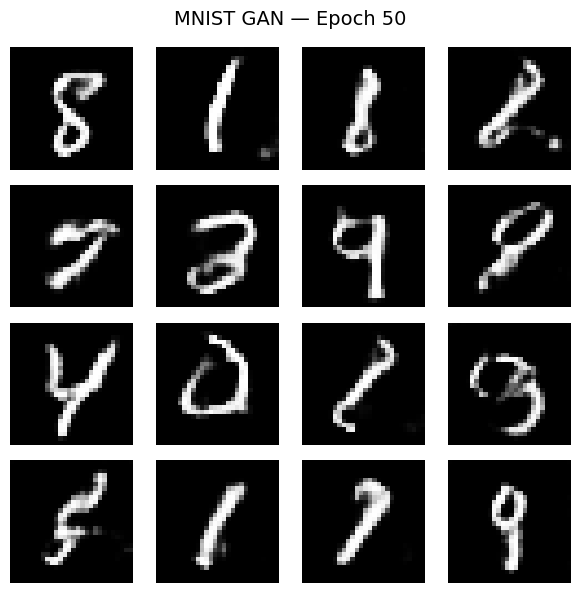

Epoch  50/50 | G Loss: 0.9737 | D Loss: 1.2142 | Time: 468.0s


In [10]:
# Train improved model
EPOCHS_V2 = 50
gen_losses_v2, disc_losses_v2 = train_v2(train_dataset, EPOCHS_V2)

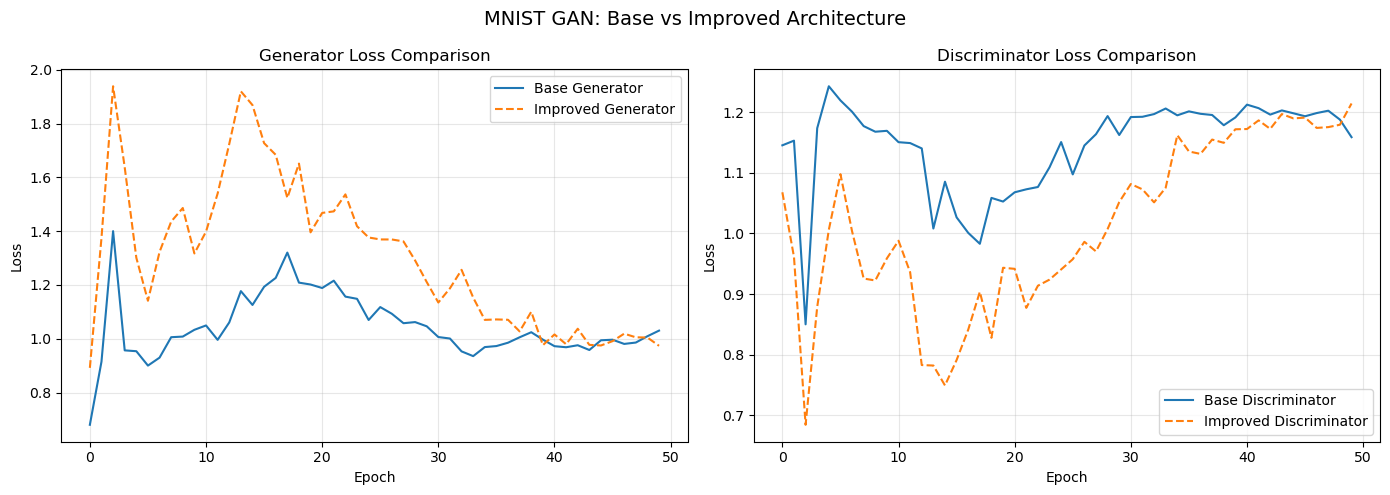

In [11]:
# Compare training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(gen_losses, label='Base Generator')
axes[0].plot(gen_losses_v2, label='Improved Generator', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(disc_losses, label='Base Discriminator')
axes[1].plot(disc_losses_v2, label='Improved Discriminator', linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Discriminator Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('MNIST GAN: Base vs Improved Architecture', fontsize=14)
plt.tight_layout()
plt.show()

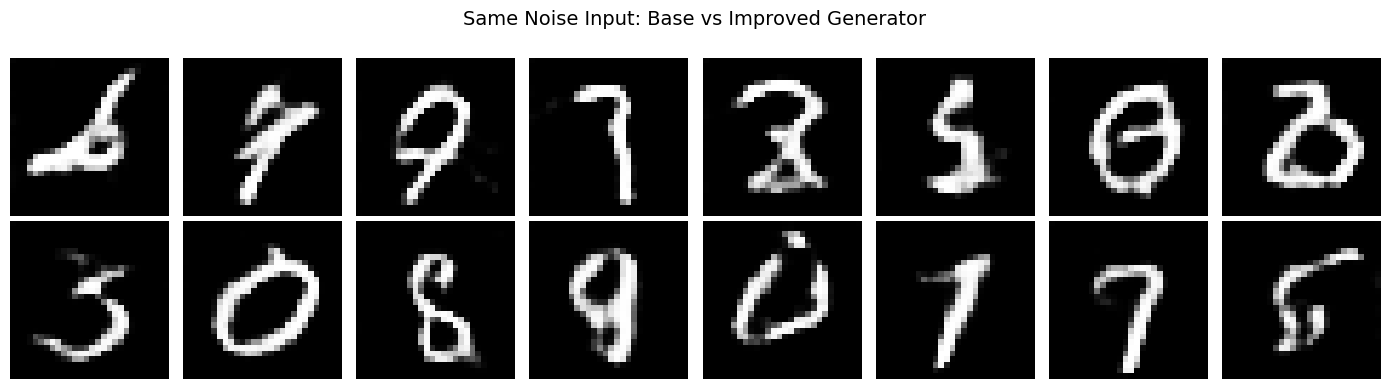

In [12]:
# Side-by-side comparison of generated samples
comparison_noise = tf.random.normal([8, NOISE_DIM])
base_images = generator(comparison_noise, training=False)
improved_images = generator_v2(comparison_noise, training=False)

fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i in range(8):
    axes[0, i].imshow(base_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(improved_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Base', fontsize=12, rotation=0, labelpad=40)
axes[1, 0].set_ylabel('Improved', fontsize=12, rotation=0, labelpad=50)
fig.suptitle('Same Noise Input: Base vs Improved Generator', fontsize=14)
plt.tight_layout()
plt.show()

## Part 3: CIFAR-10 GAN

We adapt the GAN architecture for CIFAR-10 (32×32×3 color images). Key changes:
- Generator output: 32×32×3 (instead of 28×28×1)
- Discriminator input: 32×32×3
- Deeper architecture to handle the increased complexity of natural color images

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/opt/anaconda3/envs/genai/lib/python3.11/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


CIFAR-10 training images shape: (50000, 32, 32, 3)
Pixel range: [-1.0, 1.0]
Number of batches: 391


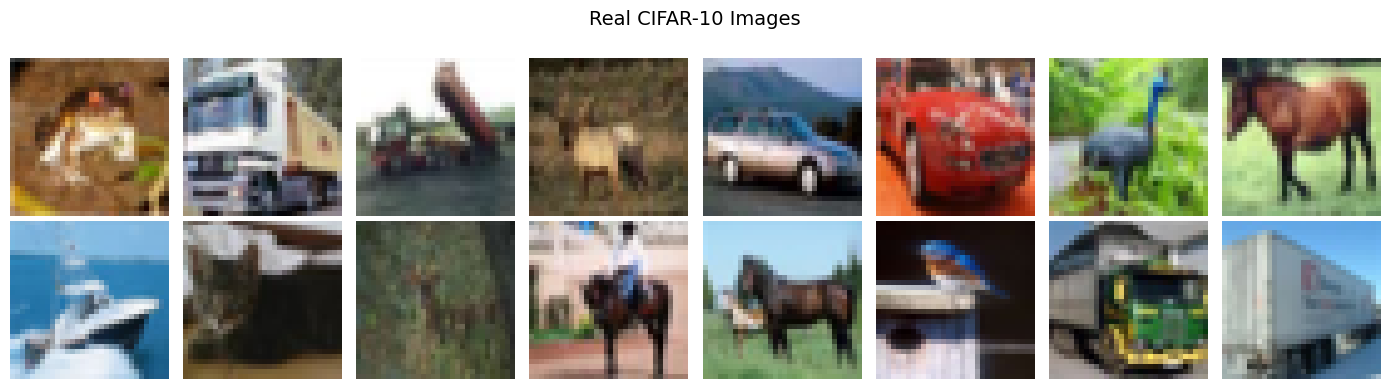

In [13]:
# Load and preprocess CIFAR-10
(cifar_train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
cifar_train_images = cifar_train_images.astype('float32')
cifar_train_images = (cifar_train_images - 127.5) / 127.5  # Normalize by 255

CIFAR_BUFFER = 50000
CIFAR_BATCH = 128

cifar_dataset = tf.data.Dataset.from_tensor_slices(cifar_train_images).shuffle(CIFAR_BUFFER).batch(CIFAR_BATCH)

print(f"CIFAR-10 training images shape: {cifar_train_images.shape}")
print(f"Pixel range: [{cifar_train_images.min():.1f}, {cifar_train_images.max():.1f}]")
print(f"Number of batches: {len(cifar_dataset)}")

# Visualize some real CIFAR-10 images
fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(cifar_train_images[i] * 0.5 + 0.5)  # Rescale
    ax.axis('off')
fig.suptitle('Real CIFAR-10 Images', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
CIFAR_NOISE_DIM = 100

def make_cifar_generator():
    """Generator for 32x32x3 CIFAR-10 images.
    Architecture: noise -> 4x4x512 -> 8x8x256 -> 16x16x128 -> 32x32x3
    """
    model = tf.keras.Sequential([
        # Project and reshape: 100 -> 4x4x512
        layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(CIFAR_NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((4, 4, 512)),

        # 4x4x512 -> 8x8x256
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Additional conv: 8x8x256 -> 8x8x256
        layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # 8x8x256 -> 16x16x128
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Additional conv: 16x16x128 -> 16x16x128
        layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # 16x16x128 -> 32x32x3
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


def make_cifar_discriminator():
    """Discriminator for 32x32x3 CIFAR-10 images."""
    model = tf.keras.Sequential([
        # 32x32x3 -> 16x16x64
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # 16x16x64 -> 8x8x128
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # 8x8x128 -> 4x4x256
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # Additional conv: 4x4x256 -> 4x4x256
        layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

cifar_generator = make_cifar_generator()
cifar_discriminator = make_cifar_discriminator()

cifar_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
cifar_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
os.makedirs('cifar_gan_images', exist_ok=True)
cifar_seed = tf.random.normal([16, CIFAR_NOISE_DIM])

def save_cifar_images(model, epoch, test_input, save_dir='cifar_gan_images'):
    """Generate and save a grid of CIFAR-10 color images."""
    predictions = model(test_input, training=False)
    # Rescale from [-1, 1] to [0, 1] for display
    predictions = predictions * 0.5 + 0.5

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(predictions[i])
        ax.axis('off')
    fig.suptitle(f'CIFAR-10 GAN — Epoch {epoch}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch:04d}.png'), dpi=100)
    plt.show()
    plt.close()

@tf.function
def cifar_train_step(images):
    noise = tf.random.normal([CIFAR_BATCH, CIFAR_NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = cifar_generator(noise, training=True)
        real_output = cifar_discriminator(images, training=True)
        fake_output = cifar_discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_grads = gen_tape.gradient(gen_loss, cifar_generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, cifar_discriminator.trainable_variables)

    cifar_gen_optimizer.apply_gradients(zip(gen_grads, cifar_generator.trainable_variables))
    cifar_disc_optimizer.apply_gradients(zip(disc_grads, cifar_discriminator.trainable_variables))

    return gen_loss, disc_loss

def train_cifar(dataset, epochs):
    gen_losses, disc_losses = [], []

    for epoch in range(1, epochs + 1):
        start = time.time()
        epoch_gen_loss, epoch_disc_loss = 0.0, 0.0
        num_batches = 0

        for image_batch in dataset:
            g_loss, d_loss = cifar_train_step(image_batch)
            epoch_gen_loss += g_loss
            epoch_disc_loss += d_loss
            num_batches += 1

        avg_gen = epoch_gen_loss / num_batches
        avg_disc = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen.numpy())
        disc_losses.append(avg_disc.numpy())

        if epoch % 10 == 0 or epoch == 1:
            save_cifar_images(cifar_generator, epoch, cifar_seed)

        elapsed = time.time() - start
        print(f'Epoch {epoch:3d}/{epochs} | G Loss: {avg_gen:.4f} | D Loss: {avg_disc:.4f} | Time: {elapsed:.1f}s')

    return gen_losses, disc_losses



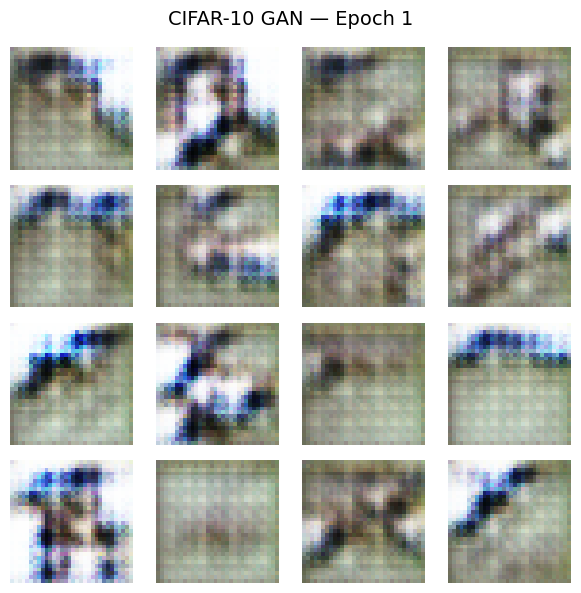

Epoch   1/100 | G Loss: 1.2751 | D Loss: 1.0076 | Time: 825.6s
Epoch   2/100 | G Loss: 1.2804 | D Loss: 0.9964 | Time: 765.8s
Epoch   3/100 | G Loss: 1.1846 | D Loss: 1.0497 | Time: 777.2s
Epoch   4/100 | G Loss: 1.2166 | D Loss: 1.0357 | Time: 779.4s
Epoch   5/100 | G Loss: 1.2580 | D Loss: 1.0269 | Time: 960.9s
Epoch   6/100 | G Loss: 1.3319 | D Loss: 0.9814 | Time: 908.8s
Epoch   7/100 | G Loss: 1.2905 | D Loss: 0.9836 | Time: 866.7s
Epoch   8/100 | G Loss: 1.3335 | D Loss: 0.9772 | Time: 856.4s
Epoch   9/100 | G Loss: 1.3049 | D Loss: 0.9933 | Time: 804.9s


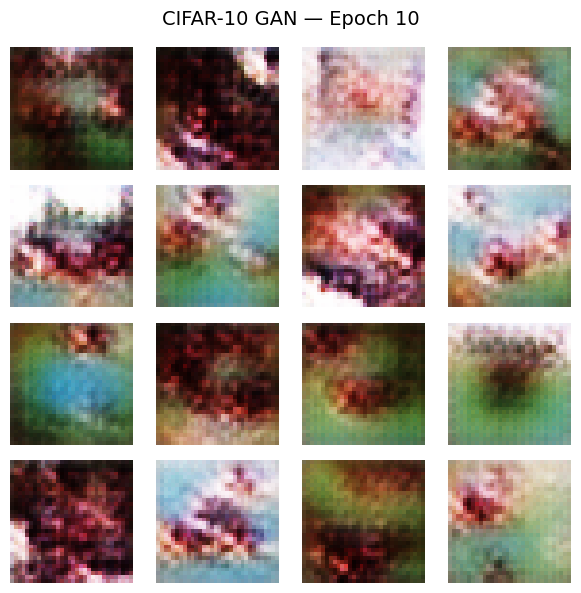

Epoch  10/100 | G Loss: 1.3022 | D Loss: 1.0040 | Time: 801.6s
Epoch  11/100 | G Loss: 1.3252 | D Loss: 1.0037 | Time: 809.6s
Epoch  12/100 | G Loss: 1.3104 | D Loss: 1.0133 | Time: 773.9s
Epoch  13/100 | G Loss: 1.3987 | D Loss: 0.9546 | Time: 761.4s
Epoch  14/100 | G Loss: 1.4410 | D Loss: 0.9304 | Time: 768.6s
Epoch  15/100 | G Loss: 1.4554 | D Loss: 0.9268 | Time: 753.7s
Epoch  16/100 | G Loss: 1.4115 | D Loss: 0.9479 | Time: 743.6s
Epoch  17/100 | G Loss: 1.3725 | D Loss: 0.9716 | Time: 761.0s
Epoch  18/100 | G Loss: 1.3994 | D Loss: 0.9652 | Time: 759.8s
Epoch  19/100 | G Loss: 1.2962 | D Loss: 1.0091 | Time: 789.5s


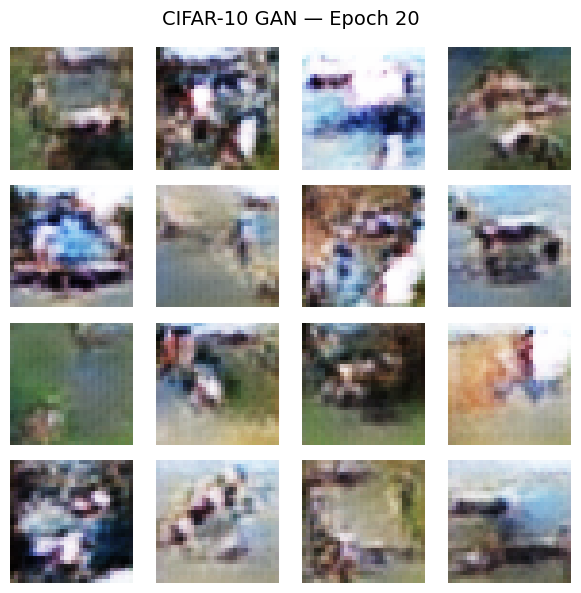

Epoch  20/100 | G Loss: 1.2993 | D Loss: 1.0052 | Time: 757.5s
Epoch  21/100 | G Loss: 1.2100 | D Loss: 1.0512 | Time: 759.2s
Epoch  22/100 | G Loss: 1.1945 | D Loss: 1.0743 | Time: 760.6s
Epoch  23/100 | G Loss: 1.1882 | D Loss: 1.0668 | Time: 783.5s
Epoch  24/100 | G Loss: 1.2156 | D Loss: 1.0546 | Time: 813.0s
Epoch  25/100 | G Loss: 1.1796 | D Loss: 1.0697 | Time: 895.7s
Epoch  26/100 | G Loss: 1.1377 | D Loss: 1.1216 | Time: 841.6s


2026-02-10 17:39:46.348784: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  27/100 | G Loss: 1.1439 | D Loss: 1.0906 | Time: 765.7s
Epoch  28/100 | G Loss: 1.1188 | D Loss: 1.1115 | Time: 773.4s
Epoch  29/100 | G Loss: 1.0661 | D Loss: 1.1361 | Time: 763.7s


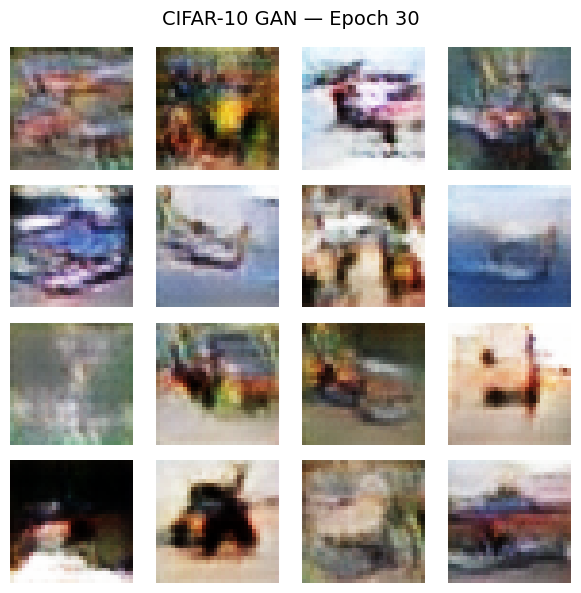

Epoch  30/100 | G Loss: 1.0587 | D Loss: 1.1452 | Time: 758.2s
Epoch  31/100 | G Loss: 1.0588 | D Loss: 1.1423 | Time: 779.4s
Epoch  32/100 | G Loss: 1.0197 | D Loss: 1.1739 | Time: 760.2s
Epoch  33/100 | G Loss: 1.0186 | D Loss: 1.1660 | Time: 766.5s
Epoch  34/100 | G Loss: 0.9680 | D Loss: 1.1944 | Time: 765.7s
Epoch  35/100 | G Loss: 0.9813 | D Loss: 1.1932 | Time: 761.0s
Epoch  36/100 | G Loss: 0.9734 | D Loss: 1.1992 | Time: 761.4s
Epoch  37/100 | G Loss: 0.9453 | D Loss: 1.2253 | Time: 787.5s
Epoch  38/100 | G Loss: 0.9623 | D Loss: 1.2094 | Time: 763.3s
Epoch  39/100 | G Loss: 0.9476 | D Loss: 1.2110 | Time: 765.3s


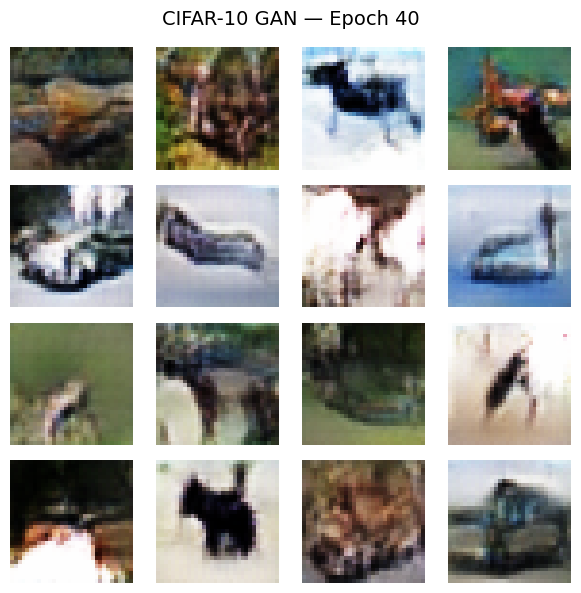

Epoch  40/100 | G Loss: 0.9429 | D Loss: 1.2173 | Time: 763.9s
Epoch  41/100 | G Loss: 0.9266 | D Loss: 1.2233 | Time: 762.7s
Epoch  42/100 | G Loss: 0.9222 | D Loss: 1.2325 | Time: 762.7s
Epoch  43/100 | G Loss: 0.9167 | D Loss: 1.2320 | Time: 759.1s
Epoch  44/100 | G Loss: 0.9128 | D Loss: 1.2282 | Time: 753.9s
Epoch  45/100 | G Loss: 0.9116 | D Loss: 1.2394 | Time: 756.8s
Epoch  46/100 | G Loss: 0.8988 | D Loss: 1.2437 | Time: 760.3s
Epoch  47/100 | G Loss: 0.9016 | D Loss: 1.2428 | Time: 773.2s
Epoch  48/100 | G Loss: 0.9037 | D Loss: 1.2415 | Time: 755.0s
Epoch  49/100 | G Loss: 0.8950 | D Loss: 1.2477 | Time: 761.8s


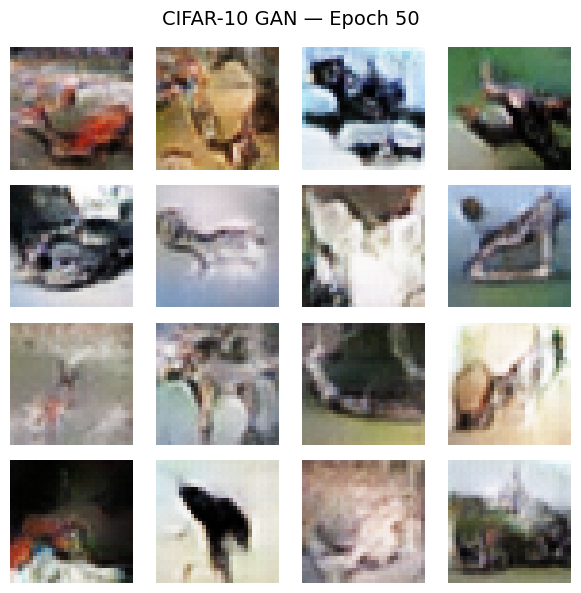

Epoch  50/100 | G Loss: 0.8917 | D Loss: 1.2494 | Time: 768.3s
Epoch  51/100 | G Loss: 0.9016 | D Loss: 1.2515 | Time: 785.0s
Epoch  52/100 | G Loss: 0.8776 | D Loss: 1.2552 | Time: 769.5s
Epoch  53/100 | G Loss: 0.8912 | D Loss: 1.2491 | Time: 768.8s
Epoch  54/100 | G Loss: 0.8923 | D Loss: 1.2514 | Time: 758.1s
Epoch  55/100 | G Loss: 0.8848 | D Loss: 1.2508 | Time: 754.4s
Epoch  56/100 | G Loss: 0.8896 | D Loss: 1.2518 | Time: 769.7s
Epoch  57/100 | G Loss: 0.8988 | D Loss: 1.2477 | Time: 756.7s
Epoch  58/100 | G Loss: 0.8913 | D Loss: 1.2474 | Time: 753.8s
Epoch  59/100 | G Loss: 0.8913 | D Loss: 1.2563 | Time: 745.3s


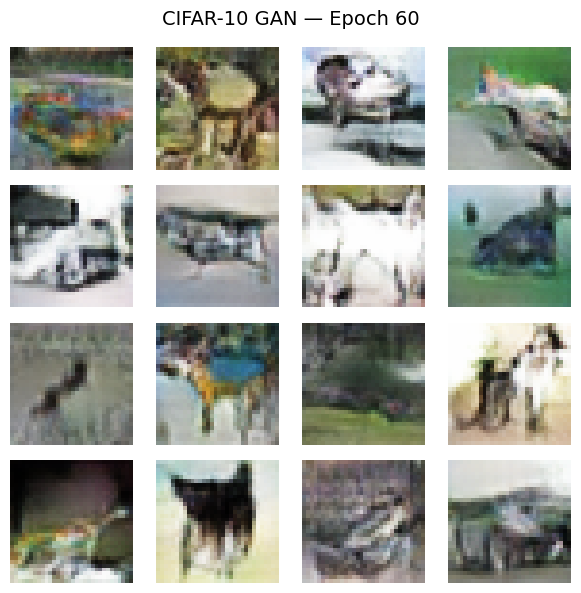

Epoch  60/100 | G Loss: 0.8782 | D Loss: 1.2589 | Time: 747.7s
Epoch  61/100 | G Loss: 0.8783 | D Loss: 1.2587 | Time: 754.2s
Epoch  62/100 | G Loss: 0.8764 | D Loss: 1.2578 | Time: 746.1s
Epoch  63/100 | G Loss: 0.8885 | D Loss: 1.2562 | Time: 744.6s
Epoch  64/100 | G Loss: 0.8905 | D Loss: 1.2495 | Time: 743.4s
Epoch  65/100 | G Loss: 0.8848 | D Loss: 1.2572 | Time: 738.4s
Epoch  66/100 | G Loss: 0.8856 | D Loss: 1.2509 | Time: 753.9s
Epoch  67/100 | G Loss: 0.8880 | D Loss: 1.2533 | Time: 2771.9s
Epoch  68/100 | G Loss: 0.8880 | D Loss: 1.2601 | Time: 14415.2s
Epoch  69/100 | G Loss: 0.8849 | D Loss: 1.2543 | Time: 7136.1s


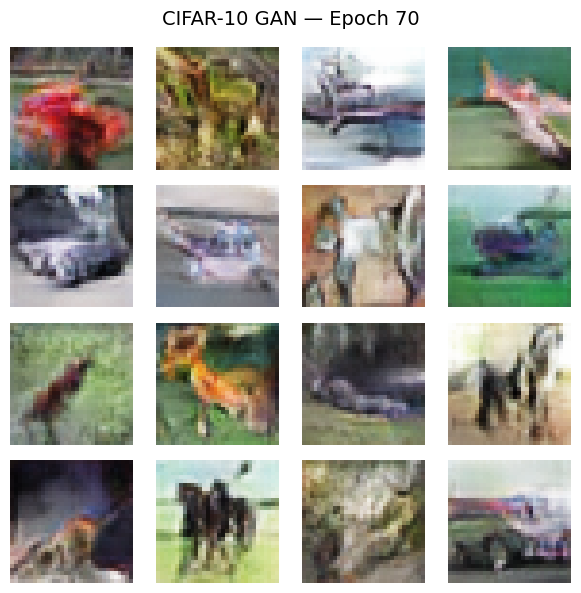

Epoch  70/100 | G Loss: 0.8951 | D Loss: 1.2486 | Time: 1897.9s
Epoch  71/100 | G Loss: 0.8782 | D Loss: 1.2629 | Time: 3588.6s
Epoch  72/100 | G Loss: 0.8839 | D Loss: 1.2578 | Time: 850.3s
Epoch  73/100 | G Loss: 0.8996 | D Loss: 1.2491 | Time: 779.9s
Epoch  74/100 | G Loss: 0.8834 | D Loss: 1.2497 | Time: 769.6s
Epoch  75/100 | G Loss: 0.8783 | D Loss: 1.2720 | Time: 775.5s
Epoch  76/100 | G Loss: 0.8918 | D Loss: 1.2460 | Time: 805.5s
Epoch  77/100 | G Loss: 0.8889 | D Loss: 1.2521 | Time: 758.5s
Epoch  78/100 | G Loss: 0.8858 | D Loss: 1.2544 | Time: 764.6s
Epoch  79/100 | G Loss: 0.9040 | D Loss: 1.2462 | Time: 764.2s


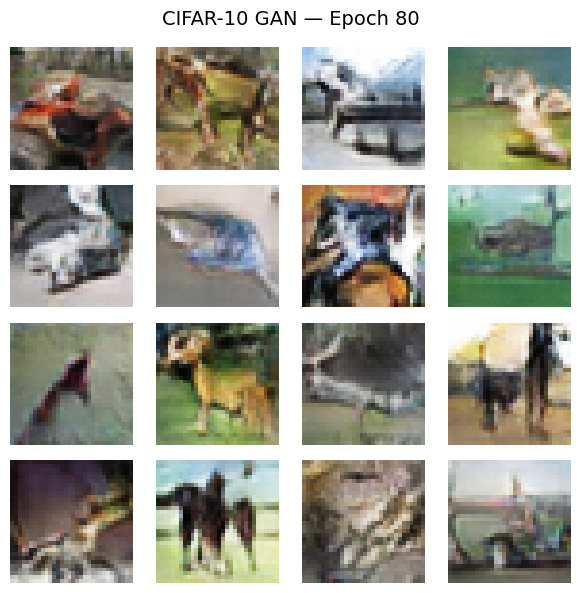

Epoch  80/100 | G Loss: 0.9027 | D Loss: 1.2405 | Time: 766.0s
Epoch  81/100 | G Loss: 0.8984 | D Loss: 1.2503 | Time: 751.7s
Epoch  82/100 | G Loss: 0.8867 | D Loss: 1.2644 | Time: 760.5s
Epoch  83/100 | G Loss: 0.9063 | D Loss: 1.2396 | Time: 752.7s
Epoch  84/100 | G Loss: 0.9058 | D Loss: 1.2393 | Time: 753.3s
Epoch  85/100 | G Loss: 0.9018 | D Loss: 1.2449 | Time: 750.8s
Epoch  86/100 | G Loss: 0.9091 | D Loss: 1.2391 | Time: 751.7s
Epoch  87/100 | G Loss: 0.8949 | D Loss: 1.2494 | Time: 746.3s
Epoch  88/100 | G Loss: 0.9207 | D Loss: 1.2321 | Time: 733.9s
Epoch  89/100 | G Loss: 0.9170 | D Loss: 1.2345 | Time: 731.3s


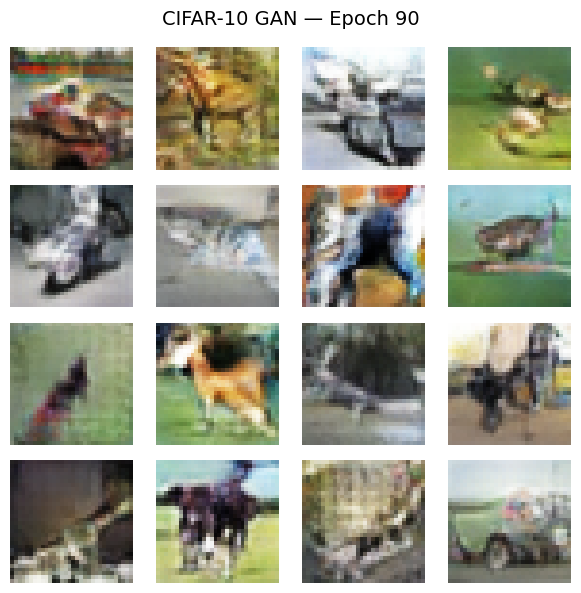

Epoch  90/100 | G Loss: 0.9286 | D Loss: 1.2251 | Time: 849.8s
Epoch  91/100 | G Loss: 0.9131 | D Loss: 1.2383 | Time: 1108.1s
Epoch  92/100 | G Loss: 0.9225 | D Loss: 1.2284 | Time: 1149.6s
Epoch  93/100 | G Loss: 0.9335 | D Loss: 1.2258 | Time: 957.9s
Epoch  94/100 | G Loss: 0.9352 | D Loss: 1.2207 | Time: 736.4s
Epoch  95/100 | G Loss: 0.9517 | D Loss: 1.2187 | Time: 991.0s
Epoch  96/100 | G Loss: 0.9261 | D Loss: 1.2252 | Time: 971.6s
Epoch  97/100 | G Loss: 0.9304 | D Loss: 1.2232 | Time: 913.4s
Epoch  98/100 | G Loss: 0.9148 | D Loss: 1.2535 | Time: 890.8s


In [ ]:
# Train 
CIFAR_EPOCHS = 100
cifar_gen_losses, cifar_disc_losses = train_cifar(cifar_dataset, CIFAR_EPOCHS)

In [2]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(cifar_gen_losses, label='Generator Loss')
plt.plot(cifar_disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CIFAR-10 GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Generate final CIFAR-10 samples
final_noise = tf.random.normal([32, CIFAR_NOISE_DIM])
final_images = cifar_generator(final_noise, training=False)
final_images = final_images * 0.5 + 0.5  # Rescale to [0, 1]

fig, axes = plt.subplots(4, 8, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(final_images[i])
    ax.axis('off')
fig.suptitle('CIFAR-10 GAN — Final Generated Samples', fontsize=14)
plt.tight_layout()
plt.show()

In this assignment I implemented three GAN configurations:

1. **Basic MNIST GAN**: A standard DCGAN with 3 transposed convolution layers in the generator and 2 convolution layers in the discriminator. This establishes our baseline for generating 28×28 grayscale digit images.

2. **Improved MNIST GAN**: Added additional 3×3 convolutional layers between each upsampling stage in the generator and between each downsampling stage in the discriminator. These extra layers provide better intermediate feature representations without changing the spatial dimensions, allowing the network to learn more complex transformations at each resolution level.

3. **CIFAR-10 GAN**: After multiple training errors, I maintained the 98 epoch training would do very well. The images generated show the progress, and I hope to run this model again soon when my computer provides the sufficient training time.

In [ ]:
# save models
